
Курсовая работа на тему:
«Анализ параметров выходных нейронов глубоких нейронных сетей»
Архитектура № 3

Импортирование библиотек

In [1]:
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

Загрузка датасета MNIST

In [2]:
MNIST_train = torchvision.datasets.MNIST('mnist_data', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('mnist_data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102355077.40it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6098252.81it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41876423.84it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22177565.50it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [3]:
MNIST_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [4]:
print(MNIST_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train


In [5]:
print(MNIST_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test


Преобразовывание данных: X_train и X_test — это изображения цифр в виде двумерных тензоров размера 28x28, приведенных к типу данных float. y_train и y_test — это метки классов, представленные в виде одномерных тензоров.

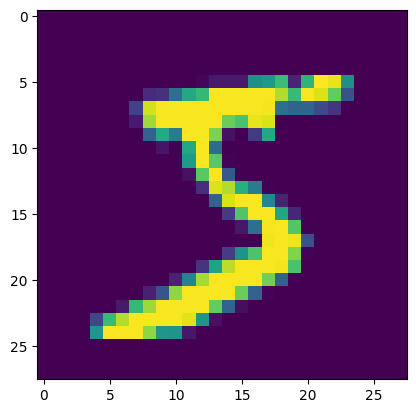

label - 5 - five


In [6]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets
plt.imshow(X_train[0, :, :])
plt.show()
print('label -', MNIST_train.classes[y_train[0]])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Создание класса LeNet5 для сверточной нейронной сети, унаследованной от класса nn.Module: два сверточных слоя self.conv1 и self.conv2, два слоя пулинга self.pool1 и self.pool2, три полносвязных слоя self.fc1, self.fc2 и self.fc3.

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
mnist_conv = LeNet5().cuda()

Обучение модели и вывод метрик

In [9]:
from sklearn.metrics import f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_tensor = X_train.cuda()
y_train_tensor = y_train.cuda()
X_test_tensor = X_test.cuda()
y_test_tensor = y_test.cuda()

batch_size = 100
num_epochs = 20
learning_rate = 0.001

mnist_conv.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

test_accuracy_history = []
test_loss_history = []
test_f1_score_history = []

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = mnist_conv(X_batch) 
        
        loss_value = criterion(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
        test_preds = mnist_conv(X_test_tensor)
        test_loss = criterion(test_preds, y_test_tensor)
        test_loss_history.append(test_loss.item())

        accuracy = (test_preds.argmax(dim=1) == y_test_tensor).float().mean()
        test_accuracy_history.append(accuracy.item())
        preds_classes = torch.argmax(test_preds, dim=1)
        f1 = f1_score(y_test_tensor.cpu().numpy(), preds_classes.cpu().numpy(), average='weighted')
        test_f1_score_history.append(f1)
        print(f"Epoch {epoch}: Test accuracy: {accuracy.item()}, Test loss: {test_loss.item()}, F1-score: {f1}") 

Using device: cuda
Epoch 0: Test accuracy: 0.9731999635696411, Test loss: 0.08492935448884964, F1-score: 0.9731783724848092
Epoch 1: Test accuracy: 0.979699969291687, Test loss: 0.060925621539354324, F1-score: 0.9796888057560839
Epoch 2: Test accuracy: 0.9842000007629395, Test loss: 0.045548759400844574, F1-score: 0.9842119188097995
Epoch 3: Test accuracy: 0.98499995470047, Test loss: 0.04850413650274277, F1-score: 0.9850097964951346
Epoch 4: Test accuracy: 0.9874999523162842, Test loss: 0.042664069682359695, F1-score: 0.9875047599035969
Epoch 5: Test accuracy: 0.9803999662399292, Test loss: 0.0705009177327156, F1-score: 0.9804281646741366
Epoch 6: Test accuracy: 0.9854999780654907, Test loss: 0.051549237221479416, F1-score: 0.9854928251757726
Epoch 7: Test accuracy: 0.9883999824523926, Test loss: 0.04085035249590874, F1-score: 0.9883978124798425
Epoch 8: Test accuracy: 0.9883999824523926, Test loss: 0.04388411343097687, F1-score: 0.9883929803946294
Epoch 9: Test accuracy: 0.9849999547

Вывод графического отражения метрики F1-score 

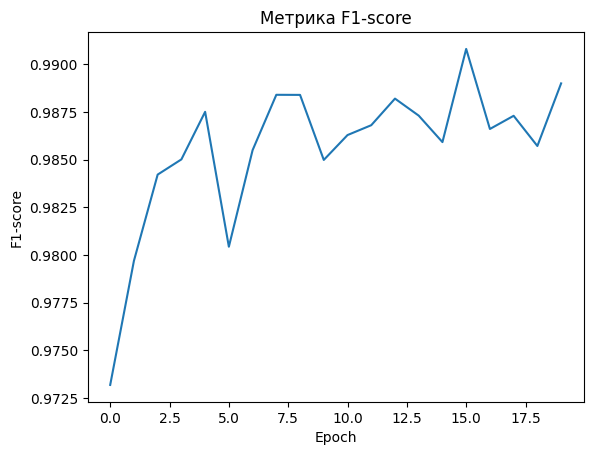

In [10]:
plt.plot(test_f1_score_history)
plt.title("Метрика F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.show()

Вывод весов последнего слоя нейронной сети

In [11]:
last_layer_weights = mnist_conv.fc3.weight
print(last_layer_weights)

Parameter containing:
tensor([[-9.4750e-02,  6.2985e-02, -3.4780e-02, -1.8250e-01, -1.2024e-02,
         -1.0629e-02, -2.1056e-01, -9.5846e-02, -2.1091e-02,  3.3520e-02,
         -1.5250e-01, -3.2030e-02, -7.8918e-02, -6.9073e-04,  6.6387e-02,
          5.8713e-02, -1.5089e-01,  9.1018e-02, -1.1131e-02, -1.1907e-01,
         -1.3447e-02,  6.0728e-02, -1.7938e-01,  3.8556e-02, -3.3723e-02,
          9.4601e-02,  1.4681e-01,  8.6009e-02,  7.6570e-02,  1.1210e-03,
          4.1212e-02,  5.1827e-02,  7.0762e-02,  4.3088e-02, -6.5170e-02,
         -3.6459e-02, -6.0453e-02, -1.2003e-01, -5.2747e-02, -1.0982e-01,
         -6.2995e-02, -5.5749e-02, -3.9821e-02,  6.9424e-02,  4.2753e-02,
         -1.4622e-01, -1.5579e-02,  5.9245e-02, -1.5738e-01,  1.4699e-02,
         -8.7670e-02,  3.9177e-02, -9.1183e-02,  3.3959e-02, -1.0978e-01,
         -1.6459e-02, -2.1542e-01,  1.2610e-02, -5.1047e-02,  1.3111e-01,
          8.7618e-02,  4.3472e-02, -1.1640e-01,  1.5435e-02, -1.7532e-01,
         -3.8654

Вывод смещений последнего слоя нейронной сети

In [12]:
last_layer_bias = mnist_conv.fc3.bias
print(last_layer_bias)

Parameter containing:
tensor([ 0.0501,  0.1320, -0.0218,  0.1178, -0.1135,  0.0285,  0.0124,  0.0671,
         0.2421,  0.0830], device='cuda:0', requires_grad=True)


Графическое отображение результатов обучения модели нейронной сети

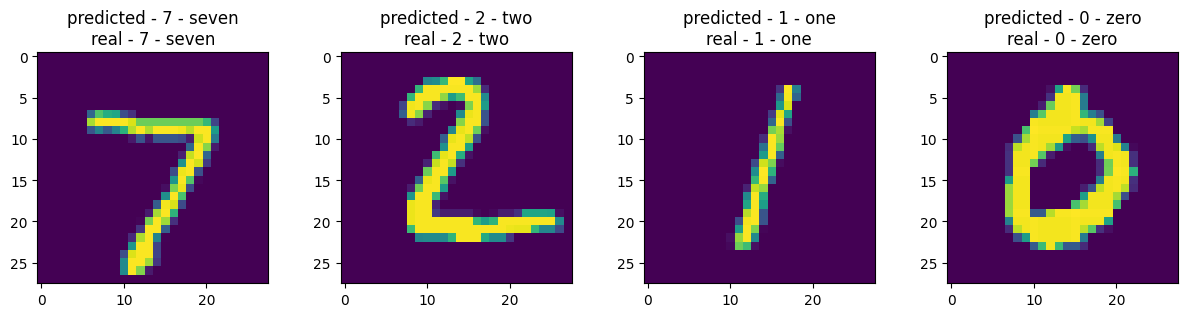

In [13]:
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    X = X.cpu().numpy()
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    for i in range(4):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')
    
show_sample(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод тепловой карты (heatmap) для матрицы попарных классификационных ошибок модели на тестовом наборе данных. 

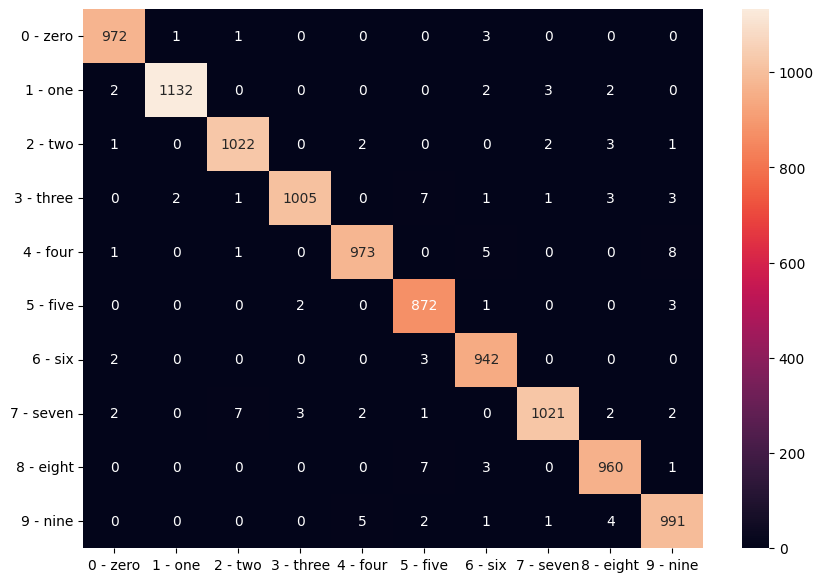

In [14]:
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes
     
    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.show()
show_matrix(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод графического отображения первого сверточного слоя

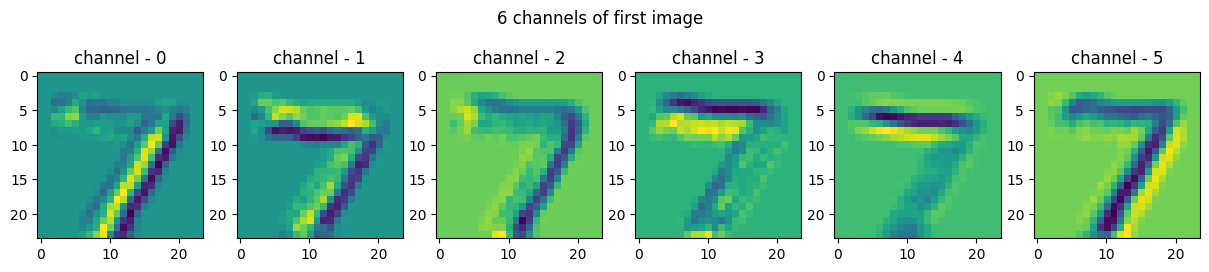

In [15]:
def show_first_conv(model, X, y, dataset):
    count = 1
    with torch.no_grad():
        first_conv = model.conv1(X)
        fig, ax = plt.subplots(1, first_conv[0].size(0), figsize=(15, 3))
        fig.suptitle(f'{first_conv[0].size(0)} channels of first image')
        for i in range(first_conv[0].size(0)):
            if count < 2:
              first_conv = first_conv.cpu().numpy()
            count = 2
            ax[i].imshow(first_conv[0][i])
            ax[i].set_title(f'channel - {i}')

show_first_conv(mnist_conv, X_test.cuda(), y_test, MNIST_test)